In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
from distribution import RBMLatentPosterior, MultivariateBernoulliNoise, ChowLiuTree

In [3]:
import numpy as np
import pdb

# my code
from distribution import RBMLatentPosterior, MultivariateBernoulliNoise, ChowLiuTree
from contrastive_divergence_optimiser import CDOptimiser
from latent_nce_optimiser import LatentNCEOptimiser
from latent_variable_model import RestrictedBoltzmannMachine
from utils import get_true_weights, plot_rbm_parameters, plot_rbm_log_likelihood_training_curves

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

# For reproducibility
rng = rnd.RandomState(1083463236)

float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

# Setup

#### data

In [4]:
n = 10000 # number of datapoints
nz = 1  # number latent samples per datapoint
nu = 1  # ratio of noise to data samples for NCE
num_gibbs_steps_for_synthetic_data = 200

#### model

In [5]:
d = 16  # visible dimension
m = 15  # latent dimension

# true_W = get_true_weights(d, m)
true_W = rnd.randn(d+1, m+1)*1 # true setting of the weights, that we are trying to learn
"""true_W = np.array([[0, 0],
                   [-3, 6],
                   [3, -6]], dtype=np.float32)
"""
true_W[0, 0] = 0

# theta0 = np.array(true_W)
theta0 = rnd.uniform(-0.5, 0.5, (d+1, m+1))  # random initialisation of weights
theta0[0, 0] = -(d+m)*np.log(2)

#### optimisation

In [6]:
# tolerances used to determine when iterations stop in scipy minimize (used in LatentNCEOptimiser)
ftol = 1e-5
maxiter = 10
stop_threshold = 1e-5
max_num_em_steps = 25

# hyperparameters used in CDOptimiser (contrastive divergence optimiser)
cd_num_steps = 1
cd_learn_rate = 0.01
cd_batch_size = 10
cd_num_epochs = 100

#### boolean switches

In [7]:
init_visible_biases_with_entropy = True
optimise_scaling_param_separately = False

use_chow_liu = False
use_marginals = True

assert use_chow_liu != use_marginals

# Data, Model & Optimiser definition

#### sample a synthetic dataset

In [8]:
%%time
true_data_dist = RestrictedBoltzmannMachine(true_W)
X, Z = true_data_dist.sample(n, num_iter=num_gibbs_steps_for_synthetic_data)

CPU times: user 1.86 s, sys: 113 ms, total: 1.97 s
Wall time: 1.95 s


In [9]:
# initialise visible biases as recommended by Hinton
X_mean = np.mean(X, axis=0)
if init_visible_biases_with_entropy:
    theta0[1:, 0] = np.log(X_mean / ((1 - X_mean) + 1e-15))
    theta0[0, 0] = -m*np.log(2) + np.sum(np.log(1 - X_mean + 1e-15))

#### initialise three models for comparison

In [10]:
model = RestrictedBoltzmannMachine(theta0)
cd_model = RestrictedBoltzmannMachine(theta0)
random_init_model = RestrictedBoltzmannMachine(theta0)

#### specify noise distribution

In [11]:
if use_chow_liu:
    noise = ChowLiuTree(X)
if use_marginals:
    noise = MultivariateBernoulliNoise(X_mean)

In [12]:
marginal_noise = MultivariateBernoulliNoise(X_mean)
chow_liu_noise = ChowLiuTree(X)
print('log likelihood of chow liu-tree noise: {}'.format(np.mean(np.log(chow_liu_noise(X)))))
print('log likelihood of marginal noise: {}'.format(np.mean(np.log(marginal_noise(X)))))
print('average prob of data under chow liu-tree noise: {}'.format(np.mean(chow_liu_noise(X))))
print('average prob of data under marginal noise: {}'.format(np.mean(marginal_noise(X))))

log likelihood of chow liu-tree noise: -5.645989985435555
log likelihood of marginal noise: -5.725301945676982
average prob of data under chow liu-tree noise: 0.013124731204975273
average prob of data under marginal noise: 0.01245410173381271


#### specify exact posterior distribution

In [13]:
var_dist = RBMLatentPosterior(theta0)  # true posterior, which has an analytic expression

#### construct optimiser

In [14]:
%%time
optimiser = LatentNCEOptimiser(model, noise, var_dist, n, nu=nu, latent_samples_per_datapoint=nz)
cd_optimiser = CDOptimiser(cd_model)

CPU times: user 1.77 ms, sys: 983 µs, total: 2.75 ms
Wall time: 2.1 ms


#### log of true normalisation constant

In [15]:
true_data_dist.reset_norm_const()
true_norm_const = true_data_dist.norm_const
true_W[0, 0] = -np.log(true_norm_const)
print('{:.4f}'.format(-np.log(true_norm_const)))

-44.0575


#### log of normalising constant for random initialisation

In [16]:
random_init_model.reset_norm_const()
rnd_norm_const = random_init_model.norm_const
print('should be reasonably close to 1: {:.4f}'.format(rnd_norm_const))

should be reasonably close to 1: 4.4257


#### starting value of scaling parameter

In [17]:
print(theta0[0,0])

-39.26916448119543


# Optimisation

In [18]:
scaling_param_ind = np.array([0])
other_param_inds = np.arange(1, len(model.theta))
all_inds = np.arange(len(model.theta))

#### optimise with respect to scaling parameter, if switch is on

In [19]:
%%time
if optimise_scaling_param_separately:
    thetas_after_em_step_scale_param, J1s_scale, nce_times_scale = optimiser.fit_using_analytic_q(X, scaling_param_ind, 
                                                                                 theta0=theta0.reshape(-1),
                                                                                  ftol=ftol, plot=False, disp=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.68 µs


In [20]:
if optimise_scaling_param_separately:
    fig = optimiser.plot_loss_curve(J1s_scale, true_theta = true_W.reshape(-1), X=X)

#### optimise with respect to all parameters

In [21]:
%%time
thetas_after_em_step, J1s, nce_times = optimiser.fit_using_analytic_q(X, theta0=model.theta, 
                                                                      disp=True, plot=False, 
                                                                      ftol=ftol, maxiter=maxiter,
                                                                      stop_threshold=stop_threshold,
                                                                      max_num_em_steps=max_num_em_steps)
latent_nce_estimate = model.theta

/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/code/latent_nce_optimiser.py:299: OptimizeWarning: Unknown solver options: ftol
  callback=callback, options={'ftol': ftol, 'maxiter': maxiter, 'disp': disp})


         Current function value: 1.400350
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20
1 EM step: J1 = -1.3929641919415066
         Current function value: 1.381346
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20
2 EM step: J1 = -1.3840825816567137
         Current function value: 1.372146
         Iterations: 10
         Function evaluations: 19
         Gradient evaluations: 19
3 EM step: J1 = -1.3727290662992762
         Current function value: 1.358460
         Iterations: 10
         Function evaluations: 20
         Gradient evaluations: 20
4 EM step: J1 = -1.360337302274945
         Current function value: 1.346557
         Iterations: 10
         Function evaluations: 22
         Gradient evaluations: 22
5 EM step: J1 = -1.351029340172297
         Current function value: 1.338821
         Iterations: 10
         Function evaluations: 22
         Gradient evaluations: 22
6 EM step: J1 = -1

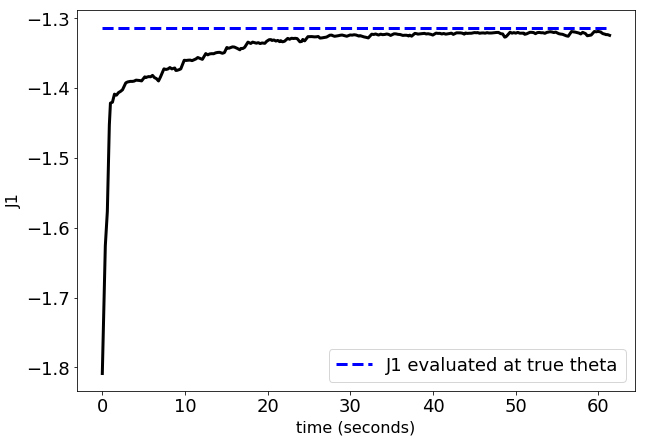

In [22]:
fig = optimiser.plot_loss_curve(end=None, true_theta = true_W.reshape(-1), X=X)

#### learn parameters using contrastive divergence

In [23]:
%%time
thetas_after_each_minibatch, cd_times = cd_optimiser.fit(X, theta0=theta0.reshape(-1), 
                                                         num_gibbs_steps=cd_num_steps,
                                                         learning_rate=cd_learn_rate, 
                                                         batch_size=cd_batch_size, 
                                                         num_epochs=cd_num_epochs)
cd_estimate =  cd_model.theta

CPU times: user 18.4 s, sys: 108 ms, total: 18.5 s
Wall time: 18.5 s


# Results

## Log-likelihood on training set

### $ \mathbb{E}_{x \sim P_{data}} \log(P_{data}(x)) \ \ \text{and} \ \ \mathbb{E}_{x \sim P_{data}} \log(P_{lnce}(x)) \ \ \text{and} \ \ \mathbb{E}_{x \sim P_{data}} \log(P_{cd}(x))  $

In [24]:
%%time
true_dist_probs_of_true_data, _ = true_data_dist.normalised_and_marginalised_over_z(X)
latent_nce_probs_of_true_data, _ = model.normalised_and_marginalised_over_z(X)
cd_probs_of_true_data, _ = cd_model.normalised_and_marginalised_over_z(X)
random_probs_of_true_data, _ = random_init_model.normalised_and_marginalised_over_z(X)
print('True:       {:.4f} \nLatent NCE: {:.4f} \nCD:         {:.4f}\nRandom init:{:.4f} \nNoise:      {:.4f}'.format(
    np.mean(np.log(true_dist_probs_of_true_data)), 
    np.mean(np.log(latent_nce_probs_of_true_data)),
    np.mean(np.log(cd_probs_of_true_data)),
    np.mean(np.log(random_probs_of_true_data)),
    np.mean(np.log(noise(X)))
))

True:       -5.5718 
Latent NCE: -5.5875 
CD:         -5.5820
Random init:-6.3157 
Noise:      -5.7253
CPU times: user 22.7 s, sys: 4.69 s, total: 27.4 s
Wall time: 27.4 s


In [25]:
# fig = plot_rbm_log_likelihood_training_curves(X, optimiser, cd_optimiser, true_data_dist, random_init_model)

### Scaling parameter

In [26]:
print('Learnt Scaling param is:              {:.4f}'.format(latent_nce_estimate[0]))
print('log of norm const of data distribution is:   {:.4f}'.format(-np.log(true_norm_const)))

Learnt Scaling param is:              -39.6132
log of norm const of data distribution is:   -44.0575


In [27]:
model.reset_norm_const()
print('We hope that the normalisation constant of the learnt model is 1. In reality it is: {} '.format(
    model.norm_const))

We hope that the normalisation constant of the learnt model is 1. In reality it is: 0.9897848276010222 


## Visualisations of parameters

In [28]:
params = [true_data_dist.theta, model.theta, cd_model.theta, random_init_model.theta]
titles = ['True parameters', 'Latent NCE parameters',  
          'Contrastive divergence parameters', 'Randomly initialised parameters']

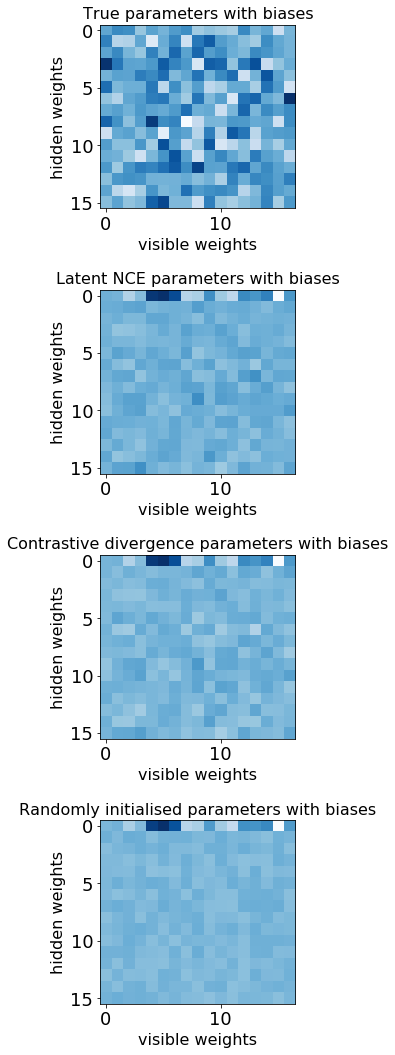

In [29]:
fig = plot_rbm_parameters(params, titles, d, m, with_bias=False, figsize=(10, 15))

## Frobenius norm of true parameters minus model parameters

In [30]:
# NOTE: we exclude the scaling parameter in all comparisons

nce_true_param_diff = (true_W - latent_nce_estimate.reshape(d+1, m+1)).reshape(-1)[1:]
sq_diff_nce_true = np.dot(nce_true_param_diff, nce_true_param_diff)**0.5

cd_true_param_diff = (true_W - cd_estimate.reshape(d+1, m+1)).reshape(-1)[1:]
sq_diff_cd_true = np.dot(cd_true_param_diff, cd_true_param_diff)**0.5

random_true_param_diff = (true_W - theta0).reshape(-1)[1:]
sq_diff_rand_true = np.dot(random_true_param_diff, random_true_param_diff)**0.5

nce_cd_param_diff = (latent_nce_estimate - cd_estimate)[1:]
sq_diff_nce_cd = np.dot(nce_cd_param_diff, nce_cd_param_diff)**0.5

print('true vs latent nce:   {:.4f}'.format(sq_diff_nce_true))
print('true vs cd:           {:.4f}'.format(sq_diff_cd_true))
print('true vs random init:  {:.4f}'.format(sq_diff_rand_true))
print('nce vs cd:            {:.4f}'.format(sq_diff_nce_cd))

true vs latent nce:   22.0187
true vs cd:           22.2852
true vs random init:  21.0243
nce vs cd:            4.2400


## Histograms of posterior distribution during learning

In [31]:
thetas = list(thetas_after_em_step)
thetas.append(true_W.reshape(-1))
num_thetas = len(thetas)

In [32]:
if m <= 5:    
    all_latents = model.get_all_binary_vectors(m)
    all_latents_tiled = np.repeat(all_latents, len(X)).reshape(len(all_latents), len(X), m)
    fig, axs = plt.subplots(int(np.ceil(num_thetas/4)), 4, figsize=(15, 7))
    axs = axs.ravel()
    for i, ax in enumerate(axs):
        if i == num_thetas:
            break
        theta_i = thetas[i]
        var_dist.alpha = theta_i.reshape(-1)
        var_dist_probs = var_dist(all_latents_tiled, X)
        ax.hist(var_dist_probs.reshape(-1), bins=int(0.1*var_dist_probs.size**0.5))
        ax.set_yticks([])

## L1 norm between model joint & true joint

$$ \| \phi - p_{data} \|_1 = \sum_{\textbf{v} \in \{0,1\}^{d}} \sum_{\textbf{h} \in \{0,1\}^{m}} |\phi(\textbf{v}, \textbf{h}) - p_{data}(\textbf{v}, \textbf{h}) | $$

In [33]:
true_model_vals = true_data_dist.evaluate_on_entire_domain(normalise=True)
latent_nce_vals = model.evaluate_on_entire_domain(normalise=False)
cd_vals = cd_model.evaluate_on_entire_domain(normalise=True)
rnd_init_vals = random_init_model.evaluate_on_entire_domain(normalise=True)

l1_norm_diff_true_nce = np.sum(np.abs(true_model_vals - latent_nce_vals))
l1_norm_diff_true_cd = np.sum(np.abs(true_model_vals - cd_vals))
l1_norm_diff_true_rnd_init = np.sum(np.abs(true_model_vals - rnd_init_vals))

print('||true - latent nce||:   {:.4f}'.format(l1_norm_diff_true_nce))
print('||true - cd||:           {:.4f}'.format(l1_norm_diff_true_cd))
print('||true - random init||:  {:.4f}'.format(l1_norm_diff_true_rnd_init))

AssertionError: Evaluating over the whole domain has O(2**(m+d)) cost. Assertion raised since m+d is equal to 31, which exceeds the current limit of 20

### log-likelihood assigned to noise

In [ ]:
print(
'Under noise dist:   {} '
'\nUnder true dist:    {} '
'\nUnder learnt model: {}'.format(
    np.mean(np.log(noise(optimiser.Y))), 
    np.mean(np.log(true_data_dist.normalised_and_marginalised_over_z(optimiser.Y)[0])),
    np.mean(np.log(model.normalised_and_marginalised_over_z(optimiser.Y)[0]))                  
    )
)

# Validation of synthetic dataset

In [ ]:
"""all_visibles = true_data_dist.get_all_binary_vectors(d)
visible_probs, true_dist_norm_const = true_data_dist.normalised_and_marginalised_over_z(all_visibles)
print('Sum over all visible probabilities should equal 1. We got: {}'.format(sum(visible_probs)))

print('-------------------------Visible probability checks--------------------------------------')
for i in range(2**d):
    freq = np.sum(np.product((X == all_visibles[i]), axis=-1))/ len(X)
    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_visibles[i], 
                                                                         freq, visible_probs[i]))
print('normalisation constant is: {}'.format(true_dist_norm_const))

all_hiddens = true_data_dist.get_all_binary_vectors(m)
hidden_probs, _ = true_data_dist.normalised_and_marginalised_over_u(all_hiddens)

print('Sum over all hidden probabilities should equal 1. We got: {}'.format(sum(hidden_probs)))

var_dist.alpha = true_W.reshape(-1)
Z_from_posterior_class = var_dist.sample(1000, X)

print('-------------------------Hidden probability checks--------------------------------------')
for i in range(2**m):
    freq = np.mean(np.product((Z_from_posterior_class == all_hiddens[i]), axis=(-1)))
    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_hiddens[i], 
                                                                         freq, hidden_probs[i]))"""